# Special Project: Forecasting Stock Prices Using Bayesian LSTM


# Bayesian LSTM
## Importing all required libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn

plt.rc(
    'figure',
    figsize=(12, 6)
)

## GET STOCK DATA

In [ ]:
def get_stock_data(symbol: str, start: str = '2017-03-21', end: str = '2022-04-19') -> pd.DataFrame:
    return yf.download(symbol, start=start, end=end).drop('Close', axis=1)

In [ ]:
stocks = ['RELIANCE.NS', 'DRREDDY.NS', 'DMART.NS', 'TCS.NS', 'HINDUNILVR.NS']

In [ ]:
df = get_stock_data(stocks[2])

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-03-21,600.000000,648.900024,558.299988,641.599976,85728445
2017-03-22,641.549988,657.450012,625.099976,638.549988,15817671
2017-03-23,637.900024,648.000000,628.150024,634.849976,4690121
2017-03-24,635.450012,640.450012,612.599976,616.900024,4865013
2017-03-27,615.000000,623.000000,602.349976,614.400024,3535098
...,...,...,...,...,...
2022-04-08,4165.000000,4208.000000,4118.000000,4146.250000,358035
2022-04-11,4136.799805,4200.000000,4130.049805,4171.600098,202944
2022-04-12,4174.950195,4174.950195,4075.000000,4088.699951,228548


### DATA PREPROCESSING

In [ ]:
df['returns'] = df['Adj Close'].pct_change()
df['returns_lag1'] = df['returns'].shift(1)
df['target'] = df['returns']
df.drop('returns', axis=1, inplace=True)
df.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1).copy()
Y = df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

#Standardising X_train and X_test
standard_scaler_x = StandardScaler()
standard_scaler_x.fit(X_train)

X_train = pd.DataFrame(standard_scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(standard_scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

#Standardising Y_train and Y_test
standard_scaler_y = StandardScaler()
standard_scaler_y.fit(Y_train.values.reshape(-1, 1))

Y_train = pd.DataFrame(standard_scaler_y.transform(Y_train.values.reshape(-1, 1)), columns=['target'], index=Y_train.index)
Y_test = pd.DataFrame(standard_scaler_y.transform(Y_test.values.reshape(-1, 1)), columns=['target'], index=Y_test.index)

In [ ]:
step=10

X_train = X_train.values.astype('float32')
Y_train = Y_train.values.astype('float32')

X = np.array([], dtype='float32').reshape(-1, step, 6)
Y = np.array([], dtype='float32').reshape(-1, 1)

for i in range(len(X_train) - step-1):
    try:
        X = np.append(X, X_train[i: i+step].reshape(1, step, -1), axis=0)
        Y = np.append(Y, Y_train[i+step].reshape(-1, 1), axis=0)
    except:
        pass

In [ ]:
dates = Y_test.index

X_test = X_test.values.astype('float32')
Y_test = Y_test.values.astype('float32')

X_val = np.array([], dtype='float32').reshape(-1, step, 6)
Y_val = np.array([], dtype='float32').reshape(-1, 1)
Y_val_dates = []

for i in range(len(X_test) - step-1):
    try:
        X_val = np.append(X_val, X_test[i: i+step].reshape(1, step, -1), axis=0)
        Y_val = np.append(Y_val, Y_test[i+step].reshape(-1, 1), axis=0)
        Y_val_dates.append(dates[i+step])
    except:
        pass
    
del dates

In [ ]:
import tensorflow as tf

tf.config.optimizer.set_jit(True)

In [ ]:
batch_size=64

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.batch(batch_size).prefetch(1) 

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(1) 

In [ ]:
X.shape, Y_val.shape

((928, 10, 6), (302, 1))

### BLSTM

In [ ]:
import tensorflow.keras.backend as k
import gc

gc.collect()
k.clear_session()

In [ ]:
import tensorflow_probability as tfp


def prob_distributions():
    tfd = tfp.distributions

    def prior(kernel_size, bias_size, dtype=None):
        n = kernel_size + bias_size
        prior_model = keras.Sequential(
            [
                tfp.layers.DistributionLambda(
                    lambda t: tfp.distributions.MultivariateNormalDiag(
                        loc=tf.zeros(n), scale_diag=tf.ones(n)
                    )
                )
            ]
        )
        return prior_model

    def posterior(kernel_size, bias_size, dtype=None):
        n = kernel_size + bias_size
        posterior_model = keras.Sequential(
            [
                tfp.layers.VariableLayer(
                    tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
                ),
                tfp.layers.MultivariateNormalTriL(n),
            ]
        )
        return posterior_model
    return prior, posterior

prior, posterior = prob_distributions()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras

def build_blstm(M: float) -> Sequential:

    def negloglik(targets, estimated_distribution):
        return -estimated_distribution.log_prob(targets)

    model = Sequential()
    model.add(LSTM(
        128, 
        activation='tanh',
        recurrent_activation='sigmoid',
        return_sequences=True,
        input_shape=(10, 6)))
    model.add(LSTM(
        100, 
        activation='tanh',
        recurrent_activation='sigmoid',
        return_sequences=False))
    model.add(tfp.layers.DenseVariational(
                units=20,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1 / 64,
                use_bias=True,
                activation="swish"))
    model.add(tfp.layers.DenseVariational(
                units=10,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1 / 64,
                use_bias=True,
                activation="swish"))
    model.add(tfp.layers.DenseVariational(
                units=2,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1 / 64,
                use_bias=True,
                activation="swish"))
    model.add(tfp.layers.IndependentNormal(1))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=negloglik, metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])

    return model

blstm = build_blstm(X.shape[0]/batch_size)

In [ ]:
blstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 100)               91600     
                                                                 
 dense_variational (DenseVar  (None, 20)               2043230   
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 10)               22365     
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (None, 2)                275       
 ariational)                                                     
                                                        

In [ ]:
with tf.device('/gpu:0'):
    history = blstm.fit(val_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
5/5 [==============================] - 22s 1s/step - loss: 5.4908 - root_mean_squared_error: 2.3421 - mae: 1.4192 - val_loss: 6.1770 - val_root_mean_squared_error: 4.8293 - val_mae: 2.9891
Epoch 2/10
5/5 [==============================] - 2s 436ms/step - loss: 10.2282 - root_mean_squared_error: 2.3977 - mae: 1.8047 - val_loss: 5.3179 - val_root_mean_squared_error: 1.5446 - val_mae: 1.1786
Epoch 3/10
5/5 [==============================] - 2s 384ms/step - loss: 13.3588 - root_mean_squared_error: 4.3247 - mae: 2.8674 - val_loss: 5.8713 - val_root_mean_squared_error: 4.8630 - val_mae: 2.9364
Epoch 4/10
5/5 [==============================] - 2s 388ms/step - loss: 7.9507 - root_mean_squared_error: 4.6864 - mae: 2.8546 - val_loss: 15.6642 - val_root_mean_squared_error: 2.9669 - val_mae: 2.1868
Epoch 5/10
5/5 [==============================] - 2s 338ms/step - loss: 8.0505 - root_mean_squared_error: 3.0125 - mae: 2.2159 - val_loss: 5.9239 - val_root_mean_squared_error: 1.7216 - val_m

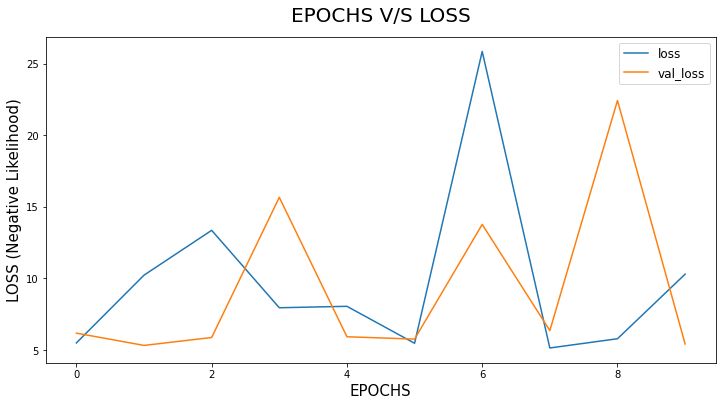

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('EPOCHS V/S LOSS', fontsize=20, pad=15)
plt.xlabel('EPOCHS', fontsize=15)
plt.ylabel('LOSS (Negative Likelihood)', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('negloglik_hindustanunilever.png', bbox_inches='tight', dpi=100)

In [ ]:
preds = blstm.predict(X_val)
preds.shape

(302, 1)

In [ ]:
def compute_prediction(model, iterations=100):
    predicted = []
    for _ in tqdm(range(iterations)):
        predicted.append(model.predict(X_val))
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1)
    prediction_std = np.std(predicted, axis=1)

    return prediction_mean,  prediction_std


preds_mean, preds_std = compute_prediction(blstm, 100)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.50it/s]


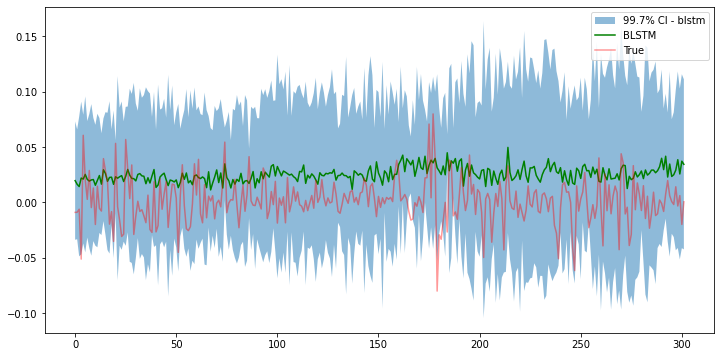

In [ ]:
plt.fill_between(range(len(X_val)),standard_scaler_y.inverse_transform(preds_mean+3*preds_std), standard_scaler_y.inverse_transform(preds_mean-3*preds_std), label='99.7% CI - blstm', alpha=0.5)
plt.plot(standard_scaler_y.inverse_transform(preds_mean), label='BLSTM', color='g')
plt.plot(standard_scaler_y.inverse_transform(Y_val.reshape(-1, 1)), label='True', color='r', alpha=0.4)
plt.legend()

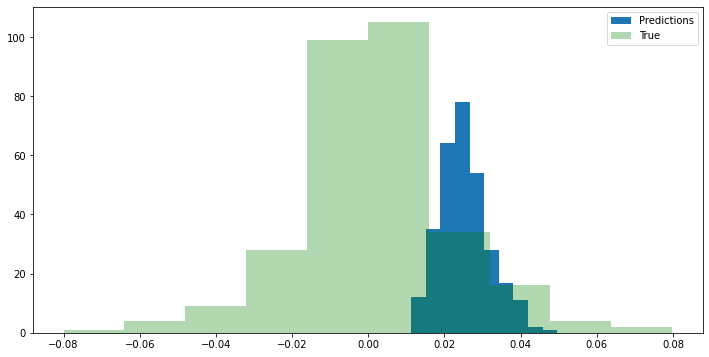

In [ ]:
plt.hist(standard_scaler_y.inverse_transform(preds_mean), label='Predictions')
plt.hist(standard_scaler_y.inverse_transform(Y_val.reshape(-1,)), alpha=0.3, label='True', color='g')
plt.legend()

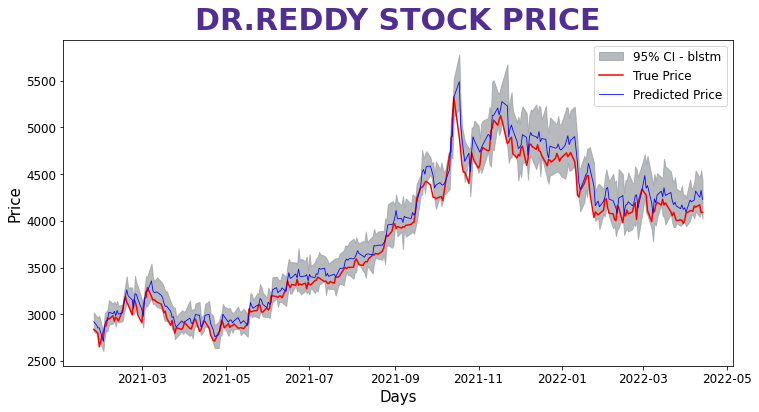

In [ ]:
preds_price = standard_scaler_x.inverse_transform(X_val[:, -1, :])[:, 3]*(1+standard_scaler_y.inverse_transform(preds_mean))
true_price =  standard_scaler_x.inverse_transform(X_val[:, -1, :])[:, 3]*(1+standard_scaler_y.inverse_transform(Y_val).reshape(-1,))
upper_pred = standard_scaler_x.inverse_transform(X_val[:, -1, :])[:, 3]*(1+standard_scaler_y.inverse_transform(preds_mean+1.96*preds_std))
lower_pred = standard_scaler_x.inverse_transform(X_val[:, -1, :])[:, 3]*(1+standard_scaler_y.inverse_transform(preds_mean-1.96*preds_std))
plt.plot(Y_val_dates, upper_pred, color='b', linewidth=0.4)
plt.plot(Y_val_dates, lower_pred, color='b', linewidth=0.4)
plt.fill_between(Y_val_dates, upper_pred, lower_pred, label='95% CI - blstm', color='#999DA0', alpha=0.7)
plt.title('DR.REDDY STOCK PRICE', fontsize=30, fontweight=600, pad=10, color='#512E91')
plt.plot(Y_val_dates, true_price, label='True Price', color='r')
plt.plot(Y_val_dates, preds_price, label='Predicted Price', color='b', linewidth=0.8)
plt.xticks(fontsize=12, fontweight=200)
plt.yticks(fontsize=12, fontweight=200)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('reliance_price.png', bbox_inches='tight', dpi=100)

## LSTM

In [ ]:
def build_lstm(lr):
    lstm = Sequential()
    lstm.add(LSTM(
        128, 
        activation='tanh',
        recurrent_activation='sigmoid',
        return_sequences=True,
        input_shape=(10, 6)))
    lstm.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
    lstm.add(Dense(25, activation='swish'))
    lstm.add(Dense(10, activation='swish'))
    lstm.add(Dense(1))
    
    lstm.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])
    
    return lstm

### Train the LSTM

In [ ]:
lstm = build_lstm(1e-3)
history = lstm.fit(val_dataset, validation_data=val_dataset, epochs=50, verbose=1)
preds_lstm = lstm.predict(X_val)

# XGBOOST
## preprocessing the data

In [ ]:
def get_stock_data(symbol: str, start: str = '2017-03-21', end: str = '2022-04-02') -> pd.DataFrame:
    return yf.download(symbol, start=start, end=end).drop('Close', axis=1)

In [ ]:
df = get_stock_data('TCS.NS')
df['returns'] = df['Adj Close'].pct_change()
df['returns_lag1'] = df['returns'].shift(1)
df['target'] = df['returns'].shift(-1)
df.drop('returns', axis=1, inplace=True)
df.dropna(inplace=True)

from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1).copy()
Y = df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

#Standardising X_train and X_test
standard_scaler_x = StandardScaler()
standard_scaler_x.fit(X_train)

X_train = pd.DataFrame(standard_scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(standard_scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

#Standardising Y_train and Y_test
standard_scaler_y = StandardScaler()
standard_scaler_y.fit(Y_train.values.reshape(-1, 1))

Y_train = pd.DataFrame(standard_scaler_y.transform(Y_train.values.reshape(-1, 1)), columns=['target'], index=Y_train.index)
Y_test = pd.DataFrame(standard_scaler_y.transform(Y_test.values.reshape(-1, 1)), columns=['target'], index=Y_test.index)

## Training the XGBoost model

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


params = {
    'objective': ['reg:squarederror'],
    'n_estimators': [50, 60, 70, 80, 90, 100],
    'learning_rate': np.arange(0.01, 0.06, 0.01),
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.5],
    'shuffle': [False],
    'verbose': [0],
    'tree_method': ['gpu_hist'],
    'predictor_method': ['gpu_predictor'],
}

model = XGBRegressor()
clf = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    
)
clf.fit(X_train, Y_train)

In [ ]:
print(clf.best_params_)
(clf.best_score_*-1)

In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)

In [ ]:
parameters = cv_results.query('rank_test_score<=10').sort_values('rank_test_score')['params']
parameters = parameters.reset_index(drop=True)

### Train the top 10 models from Cross Validation

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

cols = ['model_name','params', 'rmse', 'mae']
top_10 = pd.DataFrame(columns=cols)
i = 0
for params in parameters:
  model = XGBRegressor(**params)
  model.fit(X_train, Y_train)
  preds = model.predict(X_test)
  metrics ={
      'model_name': f'model_{i}',
      'params': params,
      'rmse': np.sqrt(MSE(Y_test, preds)),
      'mae': MAE(Y_test, preds),
  }
  top_10.loc[i] = metrics
  model.save_model(f'xgboost_mod/model_{i}.txt')
  i = i+1

In [ ]:
top_10.plot(kind='bar', grid=True)

In [ ]:
top_10.sort_values('mae')

# RANDOM FOREST

In [ ]:
# List of all stocks symbols
stocks = ['RELIANCE.NS', 'DRREDDY.NS', 'DMART.NS', 'TCS.NS', 'HINDUNILVR.NS']

In [ ]:
df=get_stock_data(stocks[4])
df['returns']=df['Adj Close'].pct_change()
df['returns lag 1']=df['returns'].shift(1)
df['target'] = df['returns'].shift(-1)
df.dropna(inplace=True)

X=df.drop('target',axis=1)
Y=df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)

standard_scaler_x = StandardScaler()
standard_scaler_x.fit(X_train)
X_train = pd.DataFrame(standard_scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(standard_scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

standard_scaler_y = StandardScaler()
standard_scaler_y.fit(Y_train.values.reshape(-1, 1))
Y_train = pd.DataFrame(standard_scaler_y.transform(Y_train.values.reshape(-1, 1)), columns=['target'], index=Y_train.index)
Y_test = pd.DataFrame(standard_scaler_y.transform(Y_test.values.reshape(-1, 1)), columns=['target'], index=Y_test.index)

In [ ]:
random_forest = RandomForestRegressor(50)
random_forest.fit(X_train, Y_train)

In [ ]:
preds = random_forest.predict(X_test)

In [ ]:
print("MAE:", MSE(Y_test, preds))
print("RMSE:", np.sqrt(MSE(Y_test, preds)))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Y_test.values, label='True')
plt.plot(preds, label='predictions')
plt.legend()

# STREAMLIT WEB APP

In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import math
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import yfinance as yf

In [ ]:
with st.sidebar:
    st.markdown("> PROJECT DONE BY THE STUDENTS ICFAI FOUNDATION OF HIGHER EDUCATION")
    st.markdown("> **MENTOR**")
    st.markdown("Ms. P ROHINI")
    st.markdown("> **STUDENTS**")
    st.markdown("Dheeraj Patel |  19STUCHH010216")
    st.markdown("Faizan Mohammed | 19STUCHH010017")
    st.markdown("Syed Anas Mohiuddin | 19STUCHH010018")

# Displaying the title of web app
st.title("Stock Market Prediction Web App")
st.markdown("> Stock Market Analysis and Prediction using data provided by Yahoo Finance.")
st.markdown("> This is web app which predicts the future value of company stocks.")


# Loading data from yahoo finance.
start=dt.date(2017,1,1)
end=dt.date.today()
data=pdr.get_data_yahoo("RELIANCE.NS", start, end)

# 'DMART.NS', 'DRREDDY.NS', "TCS.NS", "HINDUNLVR.NS"

# showing the description of data
st.subheader('Detail description about Reliance Datasets:-')
descrb=data.describe()
st.write(descrb)

# dislaying graph of open and close column
st.subheader('Graph of Close & Open :-')
st.line_chart(data[["Open","Close"]])

# displaying plot of High column in datasets
st.subheader('Graph of High:-')
st.line_chart(data['High'])

# displaying plot of Adj Close column in datasets
st.subheader('Graph of Adjusted Close:-')
st.line_chart(data['Adj Close'])

# displaying plot of volume column in datasets
st.subheader('Graph of Volume:-')
st.line_chart(data['Volume'])


#displaying random forest errors
random = pd.read_csv("random_errors.csv") 
st.title("Random Forest Errors")  
st.write(random)  

#displaying XG boost errors
xg = pd.read_csv("xgb_errors.csv")  
st.title("XG Boost Errors")  
st.write(xg)  

#displaying lstm errors
ls = pd.read_csv("lstm_errors.csv")
st.title("LSTM Errors")  
st.write(ls)  

#displaying bayesian lstm errors
bls = pd.read_csv("blstm_errors.csv")  
st.title("Bayesian LSTM Errors")  
st.write(bls)  